In [1]:
# import libraries
import numpy as np
import os
import random as rand
import seaborn as sbn
from matplotlib import pyplot as plt
import pandas as pd
from multiprocess import Pool, cpu_count
from IPython.display import clear_output
# import a library with model associated functions
import modelfn

base_directory=os.getcwd()

## Step0: 

## Input data and define Metric and Fit Objective Functions

In [2]:
# Homogeneous color scheme for the plots
colcycle={'AZ':'#1f77b4',
'TAK':'#ff7f0e',
 'LY':'#2ca02c',
 'SB':'#d62728',
 'GDC':'#9467bd',
 'DAB':'#8c564b',
 'AZ-VEM':'#e377c2',
 'VEM':'#7f7f7f',
 'PB':'#bcbd22'}
markercyc={'AZ':"o",'TAK':"s",'LY':"D",'SB':"^",'GDC':"v",'DAB':"P",'AZ-VEM':"*",'VEM':"x",'PB':"p"}


dic_inpfiles={'28pars':'SKMEL2_Karoulia_2_9Dec21.gz','30pars':'SKMEL2_Karoulia_0_9Dec21.gz',
              '28pars_normtp1':'SKMEL2_Karoulia_ff2_normtp1_1Dec21.gz','30pars_normtp1':'SKMEL2_Karoulia_ff0_normtp1_1Dec21.gz',  
             'CADP':'SKMEL2_Karoulia_ffCADP_normtp1_1Dec21.gz','NC':'SKMEL2_Karoulia_ffNC_normtp1_1Dec21.gz',
              'DP':'SKMEL2_Karoulia_ffDP_normtp1_1Dec21.gz','CA':'SKMEL2_Karoulia_ffCA_normtp1_1Dec21.gz',
              'CANC':'SKMEL2_Karoulia_ffCANC_normtp1_1Dec21.gz','DPNC':'SKMEL2_Karoulia_ffDPNC_normtp1_1Dec21.gz'
             }
modelfn.bdyglobal['rafr']=[modelfn.bdyglobal['RAF'][0]/modelfn.bdyglobal['Kdim'][1],modelfn.bdyglobal['RAF'][1]/modelfn.bdyglobal['Kdim'][0]]

def datanorm(data):
    """Inputs data for a list of drugs organized by [[pMEKdata],[pERKdata],[MEKdata]]. The pMEK and pERK data for each drug are normalized by MEK (loading control) and then each of the two rows==normalized by first element (drug=0)."""
    normdata0=[[row[0][iel]/row[-1][iel] for iel in range(len(row[0]))] for row in data]
    normdata=[[row[iel]/row[0] for iel in range(len(row)) if iel > 0] for row in normdata0]
    return normdata
drugnames=['AZ','TAK','LY','SB','GDC','DAB','AZ-VEM','VEM','PB']
drugvals=[0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10] # micro-molar
## DATA==INPUT for a list of drugs arranged as [[pMEK],[pERK],[MEK]] data for each drug with each element corresponding to above concentrations.
rawinpdata=[[[25, 55, 37, 40, 27, 17, 13, 10], [73, 119, 105, 92, 83, 50,37, 10], [34, 41, 29, 33, 32, 37, 37, 39]], [[22, 38, 49,   51, 45, 41, 25, 11], [90, 112, 139, 133, 150, 110, 58, 4], [27, 31,32, 33, 30, 31, 32, 35]], [[26, 41, 42, 39, 21, 12, 7,4], [105, 182, 159, 182, 97, 63, 13, 0.062], [59, 57, 51, 59, 53,   50, 50, 51]],[[17, 79, 83, 72, 49, 18, 5, 2], [89, 185, 182, 187, 166, 103,   15, 0.5], [32, 30, 33, 33, 32, 30, 30, 29]],[[7, 42, 63, 80, 73, 55, 23, 11], [71, 161, 176, 162, 176,   165, 118, 33], [43, 45, 40, 44, 44, 47, 47, 53]],[[25, 38, 64, 77, 84, 72, 72, 34], [110, 132, 158, 133, 161,   134, 160, 118], [51, 56, 61, 57, 55, 45, 51, 46]],[[14, 24, 31, 56, 59, 66, 73, 63], [76, 103, 124, 139, 146,   137, 153, 154], [61, 56, 55, 56, 52, 45, 55, 55]],[[26, 31, 37, 48, 48, 60, 71, 90], [113, 121, 127, 133, 133,   155, 156, 146], [68, 76, 91, 91, 91, 92, 91, 96]],[[38, 28, 34, 27, 33, 30, 35, 37], [100, 88, 79, 98, 102, 104,   98, 88], [44, 36, 42, 38, 38, 34, 36, 34]]]
normMEK=datanorm(rawinpdata)
drugvalsnorm=drugvals[1:]

cyc=[colcycle[dname] for dname in drugnames]
markr=[markercyc[dname] for dname in drugnames]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial']

In [3]:
dic_res10p=dict()
for ChooseModel in dic_inpfiles.keys(): #='CA' # CHOOSE MODEL - from the keys of the dic_inpfiles dictionary

    dfres=pd.read_csv(os.path.join(base_directory,dic_inpfiles[ChooseModel]),sep='\t')
    dfres['rafr']=dfres['RAF']/dfres['Kdim']

    setlen=lambda x:len(set(x))
    minerr=min(dfres['fitmetric'])
    max10p=minerr*1.1
    dfres10p=dfres[dfres['fitmetric']<max10p]

    print('10% of min error cutoff, number of qualifying datapoints:',minerr,max10p,setlen(dfres10p.irun))

#     dfres10describe=dfres.groupby('drug').describe()
#     dfres10describe['KA'].iloc[[0]].round(2)

    dfres10p.sort_values(by='drug',inplace=True)
    dic_res10p[ChooseModel]=dfres10p
    
    plt.rc('axes', labelsize=35)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
    plt.rc('legend', fontsize=25)    # legend fontsize
    fig1,ax1=plt.subplots(figsize=(12,12),nrows=3,sharex=True,sharey=False)
    i=-1
    for ylabel in ['Kd','f','g']:
        i+=1
        sbn.boxplot(ax=ax1[i],x='drug',whis=[2.5,97.5],y=ylabel,data=dfres10p,palette=colcycle)
        ax1[i].set_xlabel(None)
        ax1[i].set_yscale('log')
        ax1[i].set_ylim(modelfn.bdyglobal[ylabel][0]/10,modelfn.bdyglobal[ylabel][1]*10)
    ax1[i].set_xticklabels(ax1[i].get_xticklabels(), rotation=90, horizontalalignment='center')
    plt.savefig(os.path.join(base_directory,'subModel_plots',ChooseModel+'_parameter_Kd_f_g.png'),bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(2,4))
    sbn.boxplot(y='KA',data=dfres10p.drop_duplicates(subset=['irun']),whis=[2.5,97.5])
    plt.yscale('log')
    plt.ylim(modelfn.bdyglobal['KA'])
    plt.savefig(os.path.join(base_directory,'subModel_plots',ChooseModel+'_parameter_KA.png'),bbox_inches='tight')
    plt.close()
    
    plt.rc('axes', labelsize=50)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=50)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=50)    # fontsize of the tick labels
    plt.rc('legend', fontsize=20)    # legend fontsize
    def plt2(xcol,ycol):
        plt.figure(figsize=[8,8])
        for i in range(len(drugnames)):
            dataplot=dfres10p[dfres10p['drug']==drugnames[i]]
            sbn.scatterplot(x=xcol,y=ycol,data=dataplot,color=cyc[i],s=205,marker=markr[i])
        plt.xscale('log')
        plt.yscale('log')
        if xcol in modelfn.bdyglobal.keys():
            plt.xlim(modelfn.bdyglobal[xcol])
            plt.xticks(np.geomspace(modelfn.bdyglobal[xcol][0],modelfn.bdyglobal[xcol][1],5))
        if ycol in modelfn.bdyglobal.keys():
            plt.ylim(modelfn.bdyglobal[ycol])
            plt.yticks(np.geomspace(modelfn.bdyglobal[ycol][0],modelfn.bdyglobal[ycol][1],8))
        plt.legend(drugnames,loc='center left',bbox_to_anchor=(1., 0.5))#,ncol=len(drugnames))
    #     for i in range(len(drugnames)):
    #         dfres2_best=dfres2[dfres2.irun==dfres2.iloc[0].irun]
    #         sbn.scatterplot(x=xcol,y=ycol,data=dfres2_best[dfres2_best.drug==drugnames[i]],color='k',s=305,marker=markr[i],legend=None)
        plt.title('Top 10% Total fit error (<'+str(max10p)+'%)')
        if ycol=='f':
            plt.plot(modelfn.bdyglobal[xcol],[1,1],linestyle='dashed',color='k')
        plt.savefig(os.path.join(base_directory,'subModel_plots',ChooseModel+'_'+xcol+'_vs_'+ycol+'.png'),bbox_inches='tight')
        return plt.close()
    plt2('Kd','f')
clear_output()

## Tabulate results

In [4]:
dic_res10p.keys()

dict_keys(['28pars', '30pars', '28pars_normtp1', '30pars_normtp1', 'CADP', 'NC', 'DP', 'CA', 'CANC', 'DPNC'])

In [109]:
imodel='DPNC'
fround=2
Kdround=1
df_mean=(dic_res10p[imodel][['KA','f','g','Kd','drug']]).groupby(by='drug').mean()
df_mean.g=df_mean.g.round(0).astype(int).astype(str)
df_mean.f=df_mean.f.round(fround).astype(str)
df_mean.Kd=df_mean.Kd.round(Kdround).astype(str)
df_mean.KA=df_mean.KA.round(3).astype(str)

df_std=(dic_res10p[imodel][['KA','f','g','Kd','drug']]).groupby(by='drug').std()
df_std.g=df_std.g.round(0).astype(int).astype(str)
df_std.f=df_std.f.round(fround).astype(str)
df_std.Kd=df_std.Kd.round(Kdround).astype(str)
df_std.KA=df_std.KA.round(3).astype(str)
df_tab=(df_mean+'+-'+df_std).transpose()
df_tab.to_excel(os.path.join(base_directory,'subModel_plots/',imodel+'.xlsx'))
df_tab

drug,AZ,AZ-VEM,DAB,GDC,LY,PB,SB,TAK,VEM
KA,0.0+-0.0,0.0+-0.0,0.0+-0.0,0.0+-0.0,0.0+-0.0,0.0+-0.0,0.0+-0.0,0.0+-0.0,0.0+-0.0
f,1.18+-2.65,0.68+-1.19,0.01+-0.14,0.01+-0.24,1.29+-1.01,0.05+-0.26,2.91+-2.24,4.17+-2.89,0.01+-0.03
g,8+-42,11+-64,10+-31,12+-50,8+-38,12+-61,7+-46,5+-26,9+-36
Kd,2.6+-1.0,7.6+-8.6,9.1+-4.3,9.1+-7.2,1.1+-0.3,11.4+-5.3,1.8+-0.4,8.7+-4.3,11.9+-33.3


# Dose response and fit plot

In [4]:
def datanorm(data):
    """Inputs data for a list of drugs organized by [[pMEKdata],[pERKdata],[MEKdata]]. The pMEK and pERK data for each drug are normalized by MEK (loading control) and then each of the two rows==normalized by first element (drug=0)."""
    normdata0=[[row[0][iel]/row[-1][iel] for iel in range(len(row[0]))] for row in data]
    normdata=[[row[iel]/row[0] for iel in range(len(row)) if iel > 0] for row in normdata0]
    return normdata
drugnames=['AZ','TAK','LY','SB','GDC','DAB','AZ-VEM','VEM','PB']
drugvals=[0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10] # micro-molar
## DATA==INPUT for a list of drugs arranged as [[pMEK],[pERK],[MEK]] data for each drug with each element corresponding to above concentrations.
rawinpdata=[[[25, 55, 37, 40, 27, 17, 13, 10], [73, 119, 105, 92, 83, 50,37, 10], [34, 41, 29, 33, 32, 37, 37, 39]], [[22, 38, 49,   51, 45, 41, 25, 11], [90, 112, 139, 133, 150, 110, 58, 4], [27, 31,32, 33, 30, 31, 32, 35]], [[26, 41, 42, 39, 21, 12, 7,4], [105, 182, 159, 182, 97, 63, 13, 0.062], [59, 57, 51, 59, 53,   50, 50, 51]],[[17, 79, 83, 72, 49, 18, 5, 2], [89, 185, 182, 187, 166, 103,   15, 0.5], [32, 30, 33, 33, 32, 30, 30, 29]],[[7, 42, 63, 80, 73, 55, 23, 11], [71, 161, 176, 162, 176,   165, 118, 33], [43, 45, 40, 44, 44, 47, 47, 53]],[[25, 38, 64, 77, 84, 72, 72, 34], [110, 132, 158, 133, 161,   134, 160, 118], [51, 56, 61, 57, 55, 45, 51, 46]],[[14, 24, 31, 56, 59, 66, 73, 63], [76, 103, 124, 139, 146,   137, 153, 154], [61, 56, 55, 56, 52, 45, 55, 55]],[[26, 31, 37, 48, 48, 60, 71, 90], [113, 121, 127, 133, 133,   155, 156, 146], [68, 76, 91, 91, 91, 92, 91, 96]],[[38, 28, 34, 27, 33, 30, 35, 37], [100, 88, 79, 98, 102, 104,   98, 88], [44, 36, 42, 38, 38, 34, 36, 34]]]
normMEK=datanorm(rawinpdata)
drugvalsnorm=drugvals[1:]

clear_output()

In [5]:
%%time
# This block takes half an hour to run on a single core 2GhZ, 16 GB RAM machine
drugnames=['AZ','TAK','LY','SB','GDC','DAB','AZ-VEM','VEM','PB']
dvals=drugvalsnorm
dvals=[dvals[0]/100]+dvals
dvalsplot=np.geomspace(dvals[0],dvals[-1]*10,100)

dic_linplt=dict()
for ChooseModel in dic_inpfiles.keys():
    dfres10pp=dic_res10p[ChooseModel]
    dfres10p['paramsdic']=[dict(dfres10p[['Kdim','RAF','KA','f','g','Kd']].iloc[it1]) for it1 in range(len(dfres10p))]
    dflinplt=pd.DataFrame(columns=['DrugConc','pMEK/MEK','drug','irun'])
    for idx1 in range(len(dfres10p)):
        irun1=dfres10p.irun.iloc[idx1]
        idrug1=dfres10p.drug.iloc[idx1]

        dflinplt_idx=pd.DataFrame(columns=['DrugConc','pMEK/MEK','drug','irun'])
        idic=dfres10p.paramsdic.iloc[idx1]

        dflinplt_idx['DrugConc']=dvalsplot
        dflinplt_idx['pMEK/MEK']=dflinplt_idx['DrugConc'].apply(lambda iconc:modelfn.DTOT2AKnorm(iconc,idic))

        dflinplt_idx.irun=irun1
        dflinplt_idx.drug=idrug1
        dflinplt=pd.concat([dflinplt,dflinplt_idx])
        del dflinplt_idx
    clear_output()
    dic_linplt[ChooseModel]=dflinplt

Wall time: 28min 57s


In [27]:
# Plot data with along with a fit curve.

# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.family'] = ['Arial']
plt.rc('axes', labelsize=35)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=35)    # fontsize of the tick labels
plt.rc('ytick', labelsize=35)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize

for ChooseModel in dic_inpfiles.keys():
    dflinplt=dic_linplt[ChooseModel]
    ax1=plt.figure(figsize=[8,8])
    daty=normMEK
    daty=[[1.]+irow for irow in daty]
    cyc=[colcycle[dname] for dname in drugnames]
    markr=[markercyc[dname] for dname in drugnames]
    for i in range(len(daty)):
        ax1=plt.scatter(dvals,daty[i],color=cyc[i],label=drugnames[i],marker=markr[i],s=100)
    plt.legend(drugnames,bbox_to_anchor=(1,1))
    for idrug in drugnames:
        pldf=dflinplt[dflinplt.drug==idrug]
        ax1=sbn.lineplot(data=pldf,x='DrugConc',y='pMEK/MEK',ci='sd',color=colcycle[idrug],legend=False)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'Drug $(\mu$M)')
    ax1.set_ylabel('%pMEK norm to no-drug')
    plt.savefig(os.path.join(base_directory,'subModel_plots',ChooseModel+'_DoseResponse.png'),bbox_inches='tight') 
    plt.close()

## Supplementary Figure 2f

In [5]:
dic_res10p['30pars'].columns

Index(['Kdim', 'RAF', 'KA', 'f', 'g', 'Kd', 'drug', 'fitmetric', 'algorithm',
       'init', 'irun', 'rafr'],
      dtype='object')

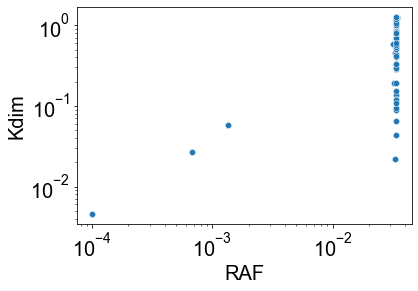

In [6]:
# Run this block ONLY when data is from the file "SKMEL2_Karoulia_0_9Dec21.gz" is input at In[3]: dfres=*
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
ChooseModel='30pars'
dfplt=dic_res10p[ChooseModel]
sbn.scatterplot(data=dfplt,x='RAF',y='Kdim')
plt.xscale('log')
plt.yscale('log')
plt.show()

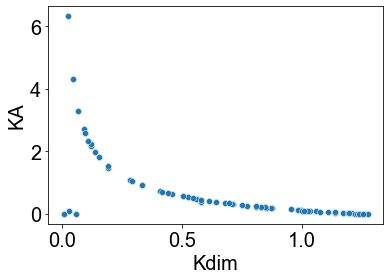

In [8]:
# Run this block ONLY when data is from the file "SKMEL2_Karoulia_0_9Dec21.gz" is input at In[3]: dfres=*
ChooseModel='30pars'
dfplt=dic_res10p[ChooseModel]
sbn.scatterplot(data=dfplt,x='Kdim',y='KA')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

## Best-Fit (10p) parameter correlations in the unified model

In [10]:
dic_res10p['28pars'].columns

Index(['Kdim', 'RAF', 'KA', 'f', 'g', 'Kd', 'drug', 'fitmetric', 'algorithm',
       'init', 'irun', 'rafr'],
      dtype='object')

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


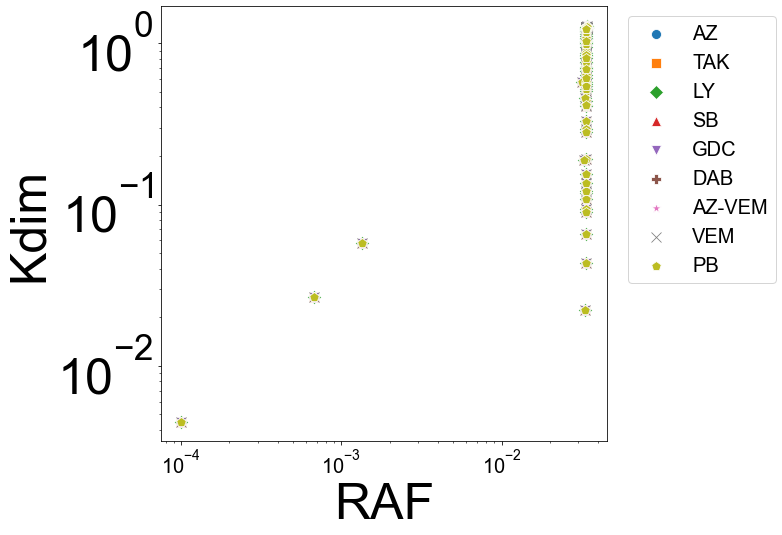

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


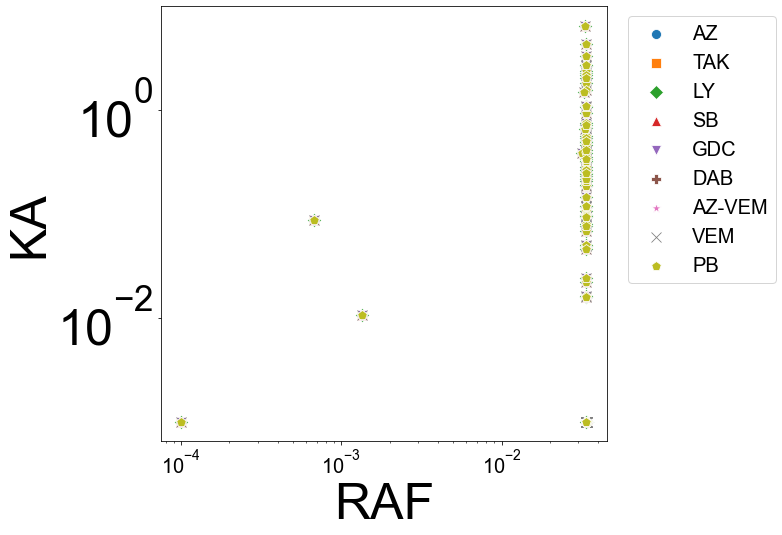

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


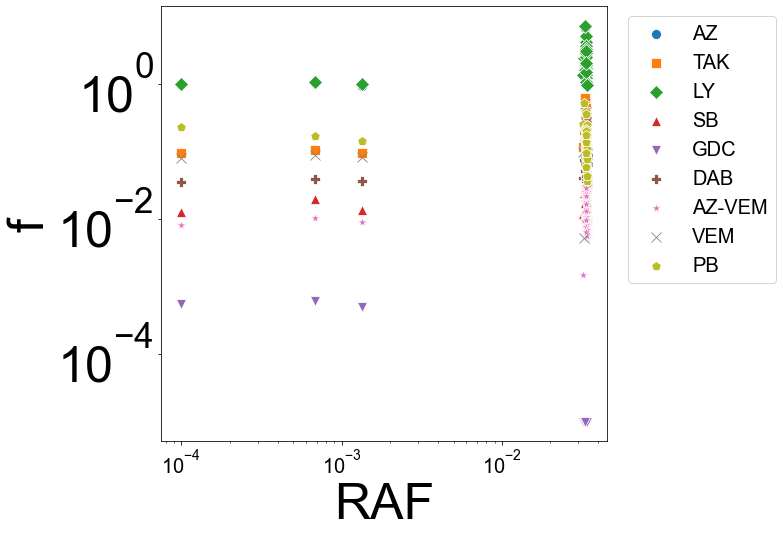

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


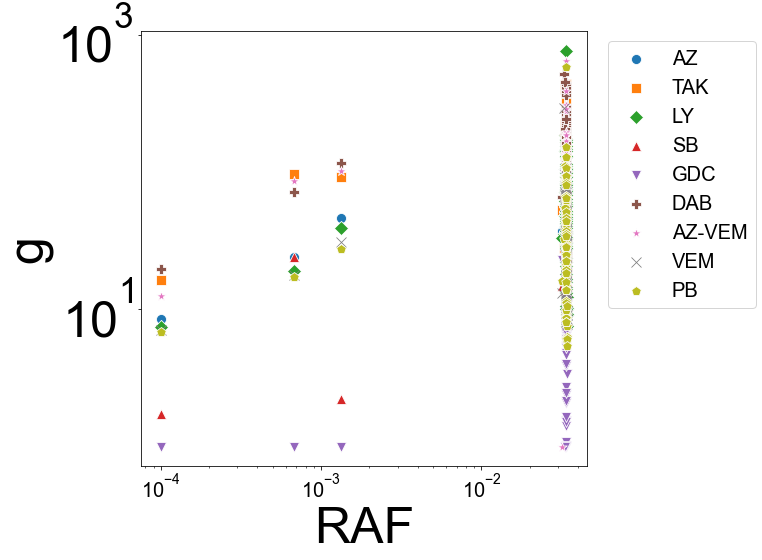

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


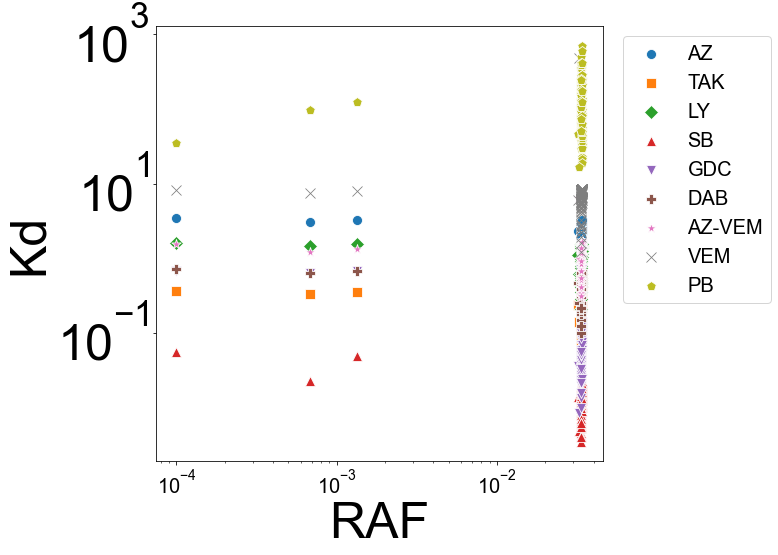

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


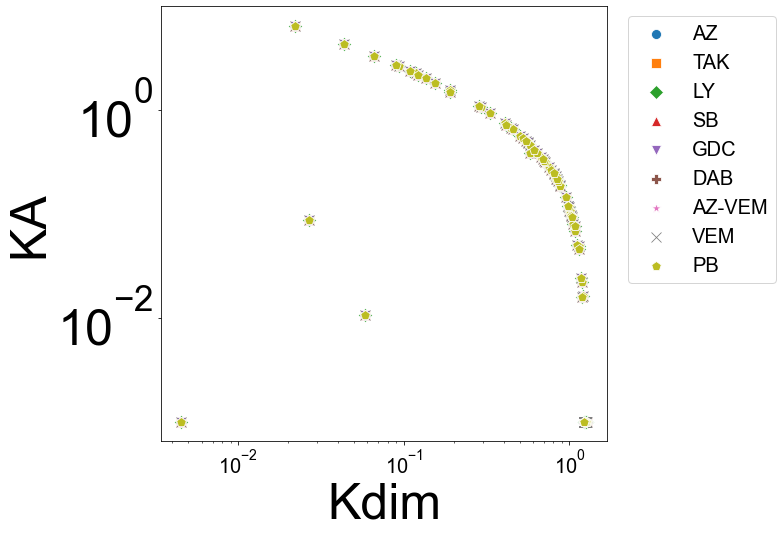

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


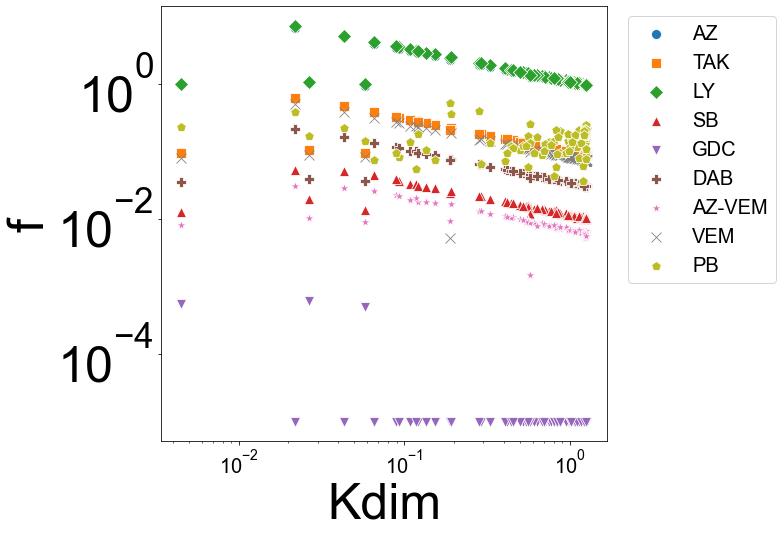

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


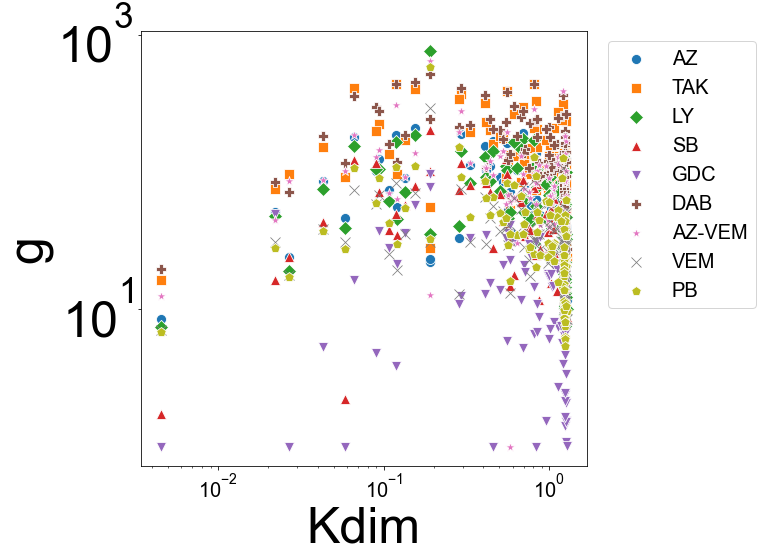

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


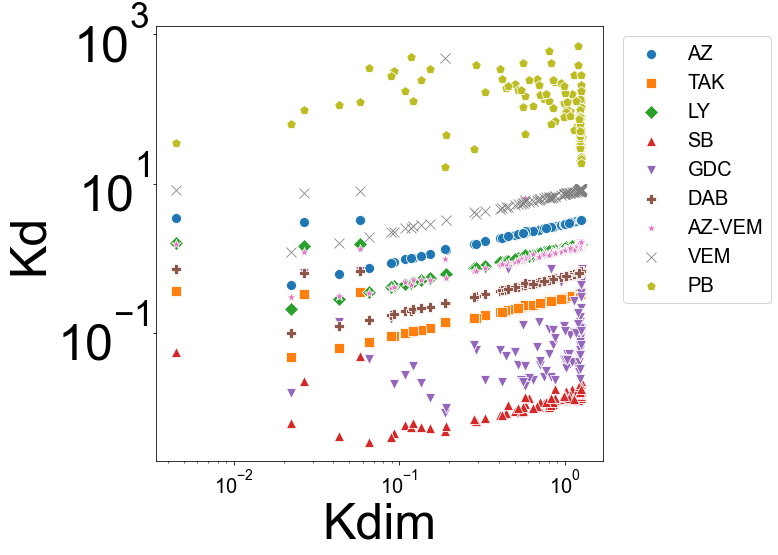

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


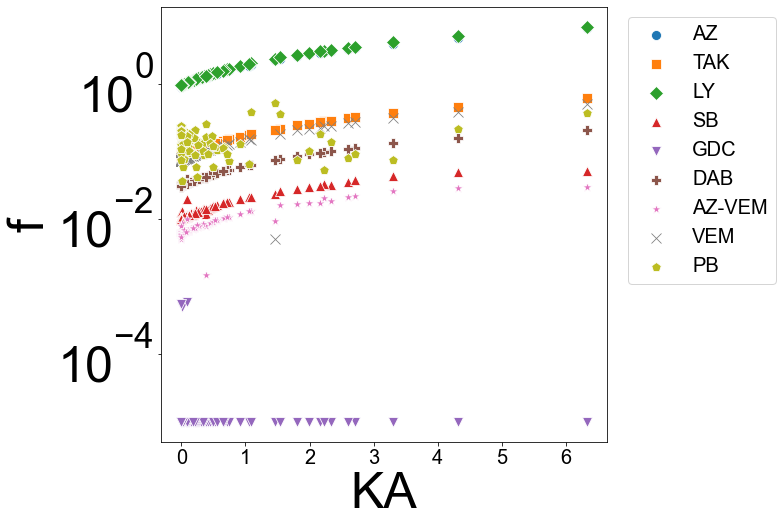

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


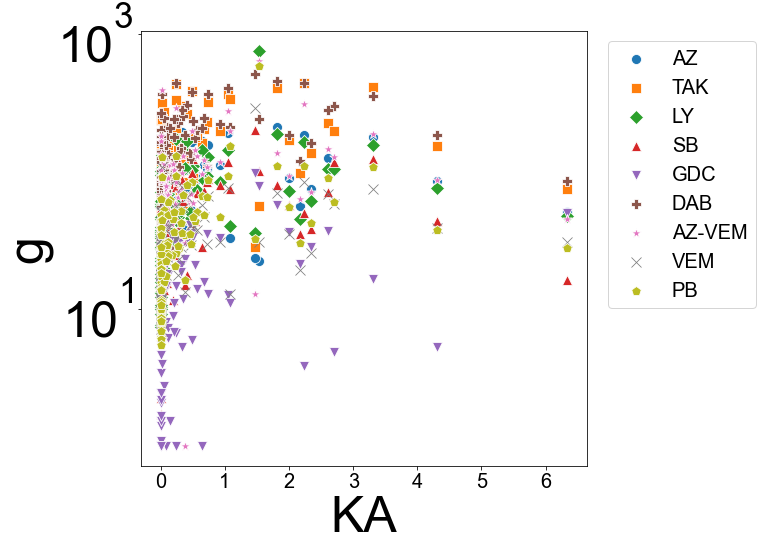

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


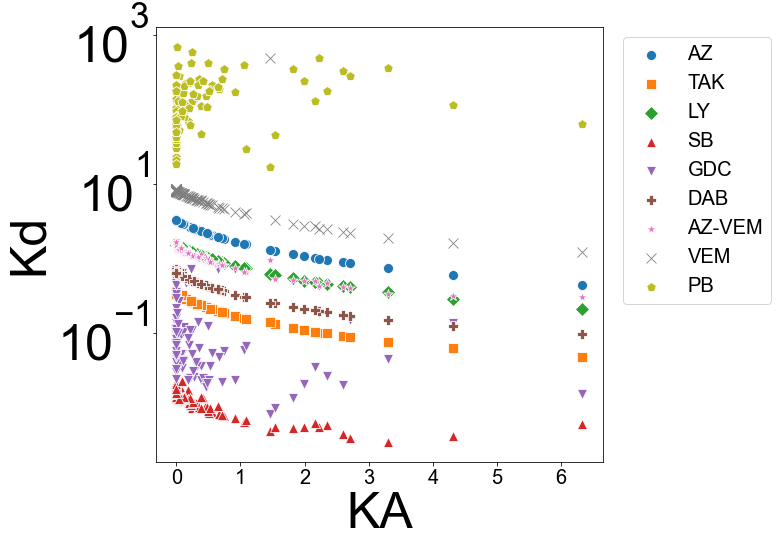

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


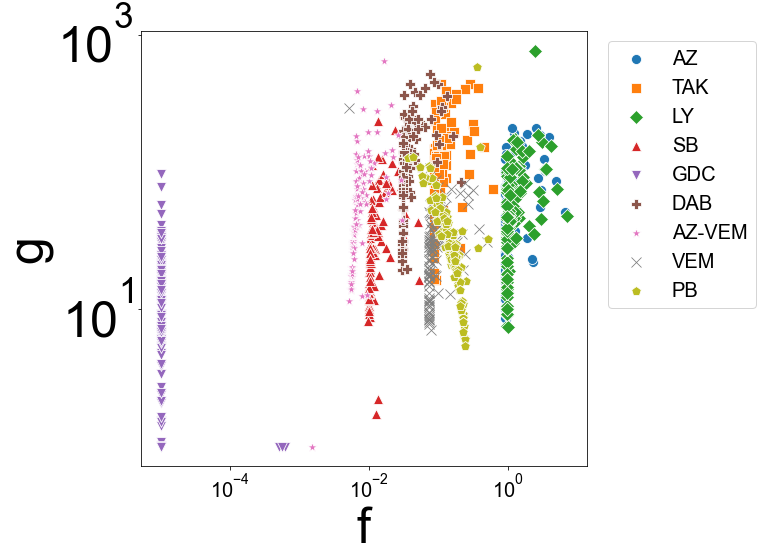

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


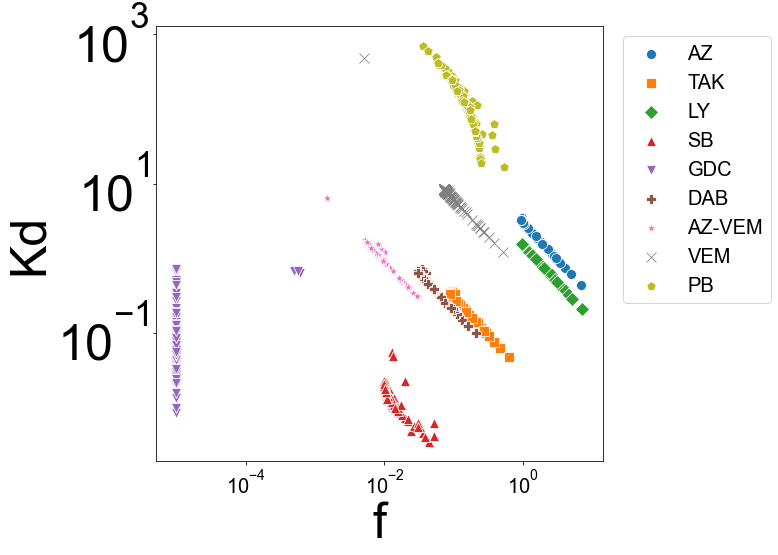

C:\Users\GM\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


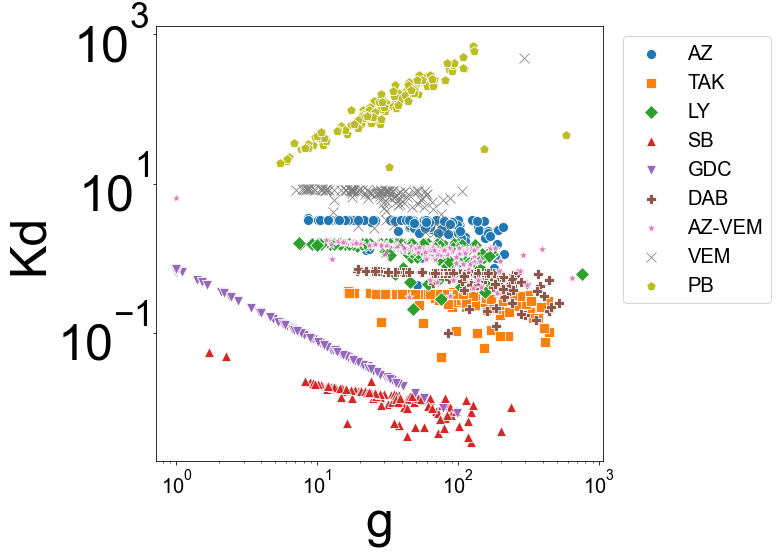

In [53]:
labelslist=['RAF','Kdim','KA', 'f', 'g', 'Kd']
pltdf=dic_res10p['30pars']
it1=0
for xlabel in labelslist:
    it1+=1
    for ylabel in labelslist[it1:]:
    
        ax1=plt.figure(figsize=[8,8])
        for idrug in drugnames:
            pldf=pltdf[pltdf.drug==idrug]
            ax1=sbn.scatterplot(data=pldf,x=xlabel,y=ylabel,color=colcycle[idrug],marker=markercyc[idrug],label=idrug,s=100)
            
        if xlabel != 'KA':
            ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        plt.legend(bbox_to_anchor=(1.4,1))
        plt.show()